# My political bubbles history

### Import Python tools and Jupyter configuration

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

In [3]:
import altair as alt
import altair_latimes as lat
import numpy as np
import matplotlib.pyplot as plt
from pywaffle import Waffle

In [4]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")

ThemeRegistry.enable('latimes')

In [5]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()
pd.options.display.max_colwidth = None

### Where have I lived (excluding pre-teen addresses and 3.5 years in Seoul (2015-2018)?

In [6]:
addresses = {
    "street": [
        "12600 Braddock Dr",
        "12701 Rubens Ave",
        "3114 15th St NE",
        "1023 Kearney St NE",
        "2604 Brisbane Rd",
        "904 Westcott St",
        "7927 Forest Ln",
        "700 W Mitchell",
        "3624 Andrea St",
    ],
    "city": [
        "Los Angeles",
        "Los Angeles",
        "Washington",
        "Washington",
        "Austin",
        "Houston",
        "Dallas",
        "Arlington",
        "Longview",
    ],
    "state": ["CA", "CA", "DC", "DC", "TX", "TX", "TX", "TX", "TX"],
    "zip": [
        "90066",
        "90066",
        "20017",
        "20017",
        "78745",
        "77007",
        "75230",
        "76013",
        "75604",
    ],
    "moved": [
        "2020",
        "2018",
        "2013",
        "2011",
        "2009",
        "2005",
        "2001",
        "1997",
        "1989",
    ],
}

In [7]:
address_df = pd.DataFrame(addresses)
address_df

,street,city,state,zip,moved
0,12600 Braddock Dr,Los Angeles,CA,90066,2020
1,12701 Rubens Ave,Los Angeles,CA,90066,2018
2,3114 15th St NE,Washington,DC,20017,2013
3,1023 Kearney St NE,Washington,DC,20017,2011
4,2604 Brisbane Rd,Austin,TX,78745,2009
5,904 Westcott St,Houston,TX,77007,2005
6,7927 Forest Ln,Dallas,TX,75230,2001
7,700 W Mitchell,Arlington,TX,76013,1997
8,3624 Andrea St,Longview,TX,75604,1989


### Make the street uppercase for later and a place column

In [8]:
address_df["street"] = address_df["street"].str.upper()

In [9]:
address_df["place"] = (
    address_df["street"]
    + ", "
    + address_df["city"]
    + ", "
    + address_df["state"]
    + ", "
    + address_df["zip"]
).str.upper()

### Format calls to Census Geocoding API to get longitude, latitude from addresses

In [10]:
formaturl = (
    lambda x: "https://geocoding.geo.census.gov/geocoder/geographies/address?street="
    + f"{x[0]}"
    + "&city="
    + f"{x[1]}"
    + "&state="
    + f"{x[2]}"
    + "&benchmark=Public_AR_Census2020&vintage=Census2020_Census2020&layers=10&format=json"
)

### Create a dictionary of addresses and coordinates

In [11]:
call_metadata = []
for s, c, t, m in zip(
    address_df["street"], address_df["city"], address_df["state"], address_df["moved"]
):
    call_metadata.append(
        dict(street=s, city=c, state=t, moved=m, url=formaturl((s, c, t)))
    )

In [12]:
call_metadata[0]

{'street': '12600 BRADDOCK DR',
 'city': 'Los Angeles',
 'state': 'CA',
 'moved': '2020',
 'url': 'https://geocoding.geo.census.gov/geocoder/geographies/address?street=12600 BRADDOCK DR&city=Los Angeles&state=CA&benchmark=Public_AR_Census2020&vintage=Census2020_Census2020&layers=10&format=json'}

### Convert returned json into a conventional dataframe and explode nexted columns

In [13]:
census_returns = []
for m in call_metadata:
    r = requests.get(m["url"])
    d = r.json()
    census_returns.append(d)

In [14]:
data = pd.DataFrame(census_returns)

In [15]:
result = pd.json_normalize(data["result"])

In [16]:
df = pd.concat(
    [pd.DataFrame(pd.json_normalize(x)) for x in result["addressMatches"]],
    ignore_index=True,
)

### Slim down the dataframe into something manageable and rename janky column names

In [17]:
location = df[
    [
        "matchedAddress",
        "coordinates.x",
        "coordinates.y",
        "addressComponents.city",
        "addressComponents.state",
        "addressComponents.zip",
    ]
].copy()

In [18]:
location.rename(
    columns={
        "matchedAddress": "address",
        "coordinates.x": "longitude",
        "coordinates.y": "latitude",
        "addressComponents.city": "city",
        "addressComponents.state": "state",
        "addressComponents.zip": "zip",
    },
    inplace=True,
)

### Simplier address column

In [19]:
location["place"] = location["city"] + ", " + location["state"] + ", " + location["zip"]

---

### Get the 'bubble' info from the NY Times app

In [20]:
# https://www.nytimes.com/interactive/2021/04/30/opinion/politics/bubble-politics.html

### Dictionary of residences and URLs to NY Times

In [21]:
bubble_urls = []

for x, y, a in zip(location["longitude"], location["latitude"], location["address"]):
    bubble_urls.append(
        dict(
            {
                "url": "https://www.nytimes.com/svc/int/run/political-bubble/?lat="
                + str(y)
                + "&lon="
                + str(x),
                "place": a,
                "address": a,
            }
        )
    )

In [22]:
# https://www.nytimes.com/svc/int/run/political-bubble/?lat=33.98673&lon=-118.42337

In [23]:
bubble_urls[0]

{'url': 'https://www.nytimes.com/svc/int/run/political-bubble/?lat=33.98673&lon=-118.42337',
 'place': '12600 BRADDOCK DR, LOS ANGELES, CA, 90066',
 'address': '12600 BRADDOCK DR, LOS ANGELES, CA, 90066'}

### Grab bubble data for each address

In [24]:
df_list = []

for u in bubble_urls:
    data = requests.get(u["url"])
    data_json = data.json()

    df = pd.DataFrame(data_json).assign(address=u["place"])
    df_list.append(df)

final_df = pd.concat(df_list).reset_index()

In [25]:
final_df.iloc[0]

index                                                 c_lat
nearest_oasis                                       33.7801
nearest_bubble                                      33.9765
user_neighbors                                          NaN
address           12600 BRADDOCK DR, LOS ANGELES, CA, 90066
Name: 0, dtype: object

### Remove rows where party column is na and drop/rename columns

In [26]:
slim_df = final_df.dropna(subset=["user_neighbors"]).copy()

In [27]:
slim_df.drop(["nearest_oasis", "nearest_bubble"], axis=1, inplace=True)

In [28]:
slim_df.rename(columns={"index": "party", "user_neighbors": "share"}, inplace=True)

### Merge residences metadata with bubble data

In [29]:
chart_df = pd.merge(address_df, slim_df, left_on="place", right_on="address")

### Chart friendly address label

In [30]:
chart_df["label"] = (
    chart_df["city"] + ", " + chart_df["state"] + " (" + chart_df["moved"] + ")"
)

### Better party labels

In [31]:
chart_df.loc[chart_df["party"] == "dem", "party"] = "Democratic"
chart_df.loc[chart_df["party"] == "rep", "party"] = "Republican"
chart_df.loc[chart_df["party"] == "ind", "party"] = "Independent"

In [32]:
chart_df

,street,city,state,zip,moved,place,party,share,address,label
0,12600 BRADDOCK DR,Los Angeles,CA,90066,2020,"12600 BRADDOCK DR, LOS ANGELES, CA, 90066",Democratic,0.845,"12600 BRADDOCK DR, LOS ANGELES, CA, 90066","Los Angeles, CA (2020)"
1,12600 BRADDOCK DR,Los Angeles,CA,90066,2020,"12600 BRADDOCK DR, LOS ANGELES, CA, 90066",Republican,0.153,"12600 BRADDOCK DR, LOS ANGELES, CA, 90066","Los Angeles, CA (2020)"
2,12600 BRADDOCK DR,Los Angeles,CA,90066,2020,"12600 BRADDOCK DR, LOS ANGELES, CA, 90066",Independent,0.002,"12600 BRADDOCK DR, LOS ANGELES, CA, 90066","Los Angeles, CA (2020)"
3,12701 RUBENS AVE,Los Angeles,CA,90066,2018,"12701 RUBENS AVE, LOS ANGELES, CA, 90066",Democratic,0.853,"12701 RUBENS AVE, LOS ANGELES, CA, 90066","Los Angeles, CA (2018)"
4,12701 RUBENS AVE,Los Angeles,CA,90066,2018,"12701 RUBENS AVE, LOS ANGELES, CA, 90066",Republican,0.146,"12701 RUBENS AVE, LOS ANGELES, CA, 90066","Los Angeles, CA (2018)"
5,12701 RUBENS AVE,Los Angeles,CA,90066,2018,"12701 RUBENS AVE, LOS ANGELES, CA, 90066",Independent,0.001,"12701 RUBENS AVE, LOS ANGELES, CA, 90066","Los Angeles, CA (2018)"
6,3114 15TH ST NE,Washington,DC,20017,2013,"3114 15TH ST NE, WASHINGTON, DC, 20017",Democratic,0.957,"3114 15TH ST NE, WASHINGTON, DC, 20017","Washington, DC (2013)"
7,3114 15TH ST NE,Washington,DC,20017,2013,"3114 15TH ST NE, WASHINGTON, DC, 20017",Republican,0.036,"3114 15TH ST NE, WASHINGTON, DC, 20017","Washington, DC (2013)"
8,3114 15TH ST NE,Washington,DC,20017,2013,"3114 15TH ST NE, WASHINGTON, DC, 20017",Independent,0.007,"3114 15TH ST NE, WASHINGTON, DC, 20017","Washington, DC (2013)"
9,1023 KEARNEY ST NE,Washington,DC,20017,2011,"1023 KEARNEY ST NE, WASHINGTON, DC, 20017",Democratic,0.954,"1023 KEARNEY ST NE, WASHINGTON, DC, 20017","Washington, DC (2011)"


### Chart it!

In [225]:
chart = (
    alt.Chart(chart_df)
    .mark_bar(opacity=0.7)
    .encode(
        x=alt.X(
            "share",
            stack="normalize",
            axis=alt.Axis(
                format="%",
                tickCount=6,
                tickSize=0,
                domainOpacity=0,
                offset=4,
                gridWidth=0.6,
                gridColor="#dddddd",
            ),
            title="Party %",
        ),
        y=alt.Y(
            "label",
            title=" ",
            sort=alt.SortField("moved"),
            axis=alt.Axis(
                tickSize=0,
                domainOpacity=0,
                tickCount=2,
                offset=4,
                gridWidth=0.6,
                gridColor="#dddddd",
            ),
        ),
        color=alt.Color(
            "party",
            title=" ",
            scale=alt.Scale(
                domain=["Democratic", "Republican", "Independent"],
                range=["#5789b8", "#d94f54", "#af8dc3"],
            ),
        ),
    )
    .properties(
        width=600, height=330, title="Current party preferences in places I've lived"
    )
    .configure_view(strokeOpacity=0)
    .configure_axis(labelFontSize=12)
    .configure_legend(orient="top", symbolType="square")
)
chart

alt.Chart(...)

In [220]:
chart_df_grp = (
    chart_df[chart_df["label"] == "Longview, TX (1989)"]
    .groupby(["label", "party"])
    .agg({"share": "mean"})
    .reset_index()
)
chart_df_grp["share_1000"] = chart_df_grp["share"] * 1000

In [221]:
chart_df_grp["label"].unique()

array(['Longview, TX (1989)'], dtype=object)

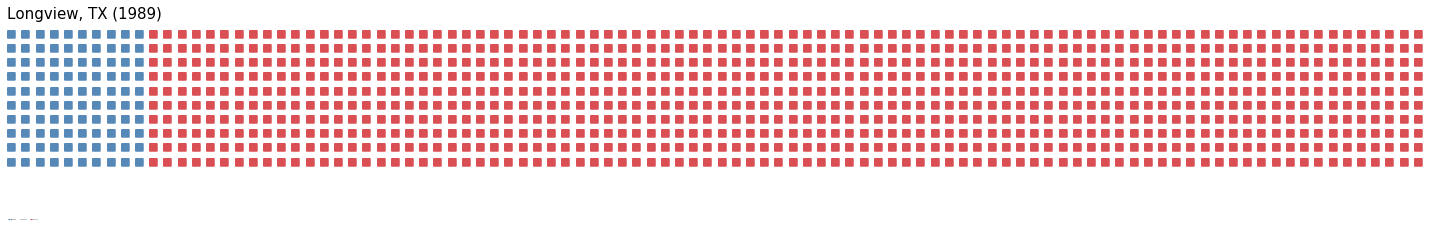

In [223]:
for l in chart_df_grp[chart_df_grp["label"] == "Longview, TX (1989)"]["label"].unique():
    fig = plt.figure(
        FigureClass=Waffle,
        rows=10,
        values=list(chart_df_grp["share_1000"]),
        labels=list(chart_df_grp["party"]),
        colors=["#5789b8", "#e1e1e1", "#d94f54"],
        font_size=10,
        figsize=(20, 5),
        icons="square",
        legend={
            "labels": ["Democratic", "Independent", "Republican"],
            "loc": "lower left",
            "bbox_to_anchor": (0, -0.4),
            "ncol": len(chart_df_grp),
            "framealpha": 0,
            "fontsize": 0,
        },
        title={
            "label": l,
            "loc": "left",
            "fontdict": {"fontsize": 15},
        },
        starting_location="NW",
    )

---

### Exports

In [35]:
chart.save("party_share_stacked_bar.png", scale_factor=1)

In [36]:
chart_df.to_csv("output/bubbles.csv", index=False)